# FOR TESTING PURPOSES ONLY

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import DataLoader, random_split
import gc
import matplotlib.pyplot as plt
from torchvision.models import resnet50

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


## Function to load data in pytorch DataLoader


In [4]:
def data_loader(data_path, batch_size, random_seed=42, shuffle=True):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.ImageFolder(data_path, transform=transform)
    
    train_size = int(0.85 * len(dataset))
    val_size = int(len(dataset)-train_size)

    train_data, val_data = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(random_seed))

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=shuffle)

    return train_loader, val_loader

In [5]:
dataset_path = "./train_dataset"
batch_size = 64

train_loader, val_loader = data_loader(dataset_path,batch_size)

print(len(train_loader))
print(len(val_loader))


111
20


## Function to save training plot

In [10]:
def save_plots(train_acc, train_loss, train_roc_auc, val_acc, val_loss, val_roc_auc):
    epochs = range(1, len(train_acc) + 1)

    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    axs[0].plot(epochs, train_loss, color='red', linestyle='-', label='Train Loss')
    axs[0].plot(epochs, val_loss, color='blue', linestyle='-', label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Loss')
    axs[0].legend()
    
    axs[1].plot(epochs, train_acc, color='red', linestyle='-', label='Train Accuracy')
    axs[1].plot(epochs, val_acc, color='blue', linestyle='-', label='Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].legend()
    
    axs[2].plot(epochs, train_roc_auc, color='red', linestyle='-', label='Train ROC-AUC')
    axs[2].plot(epochs, val_roc_auc, color='blue', linestyle='-', label='Validation ROC-AUC')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('ROC-AUC')
    axs[2].set_title('ROC-AUC')
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    train_acc.clear()
    train_loss.clear()
    train_roc_auc.clear()
    val_acc.clear()
    val_loss.clear()
    val_roc_auc.clear()

In [11]:
test_path = 'test_dataset'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Function to train model

In [12]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def train_and_validate_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, patience=5, save_path='best_model.pth'):
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    train_roc_auc_list = []
    val_roc_auc_list = []

    model.to(device)

    best_auc_loss = np.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_labels = []
        all_train_predictions = []

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.sigmoid(outputs).round()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_train_labels.extend(labels.detach().cpu().numpy())
            all_train_predictions.extend(predicted.detach().cpu().numpy())

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        train_roc_auc = roc_auc_score(all_train_labels, all_train_predictions)
        train_roc_auc_list.append(train_roc_auc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_labels = []
        all_val_predictions = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                predicted = torch.sigmoid(outputs).round()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_val_labels.extend(labels.detach().cpu().numpy())
                all_val_predictions.extend(predicted.detach().cpu().numpy())

        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(100 * val_correct / val_total)

        val_roc_auc = roc_auc_score(all_val_labels, all_val_predictions)
        val_roc_auc_list.append(val_roc_auc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, "
              f"Train ROC-AUC: {train_roc_auc:.4f}, "
              f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%, "
              f"Val ROC-AUC: {val_roc_auc:.4f}")

        if val_roc_auc[-1] < best_auc_loss:
            best_auc_loss = val_roc_auc[-1]
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Validation AUC decreased, saving model to {save_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    save_plots(train_acc, train_loss, train_roc_auc_list, val_acc, val_loss, val_roc_auc_list)

## Model definition and training

In [13]:
import torch.nn as nn
import torch.optim as optim
import torch
class_weights = torch.tensor([0.1, 0.9])
model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
criterion = nn.BCEWithLogitsLoss(weight=class_weights)
optim = optim.Adam(model.parameters(),lr=0.001)
num_epoch = 20
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
import torch.nn as nn
import torch.optim as optim
import torch

model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
criterion = nn.BCEWithLogitsLoss()
optim = optim.Adam(model.parameters(),lr=0.001)
num_epoch = 20

train_and_validate_model(model,criterion,optim,num_epoch,train_loader,val_loader)

Epoch 1/20 - Validation: 100%|██████████| 20/20 [00:06<00:00,  3.05it/s]

Epoch 1/20, Train Loss: 0.1914, Train Acc: 95.99%, Train ROC-AUC: 0.5011, Val Loss: 0.1697, Val Acc: 93.42%, Val ROC-AUC: 0.5430


IndexError: invalid index to scalar variable.

## Extract features from Training Set

In [16]:
model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load('best_model.pth'))
model = nn.Sequential(*list(model.children())[:-1])
model.to(device)

/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_98324/946476707.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.p

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
path = 'train_dataset'

dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [21]:
features = []
labels = []
print(device)

mps


In [22]:
model.eval()

with torch.no_grad():
    for images, label in dataloader:
        images = images.to(device)
        output = model(images)
        output = output.view(output.size(0), -1)
        features.append(output.cpu())
        labels.append(label.cpu())
features = torch.cat(features)
labels = torch.cat(labels)

In [23]:
torch.save(features, 'features2.pth')
torch.save(labels, 'labels2.pth')

In [24]:
features = torch.load('features2.pth')
labels = torch.load('labels2.pth')

/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_98324/2227334752.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load('features2.pth')
/var/f

In [25]:
features_np = features.numpy()
labels_np = labels.numpy()

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features_np)

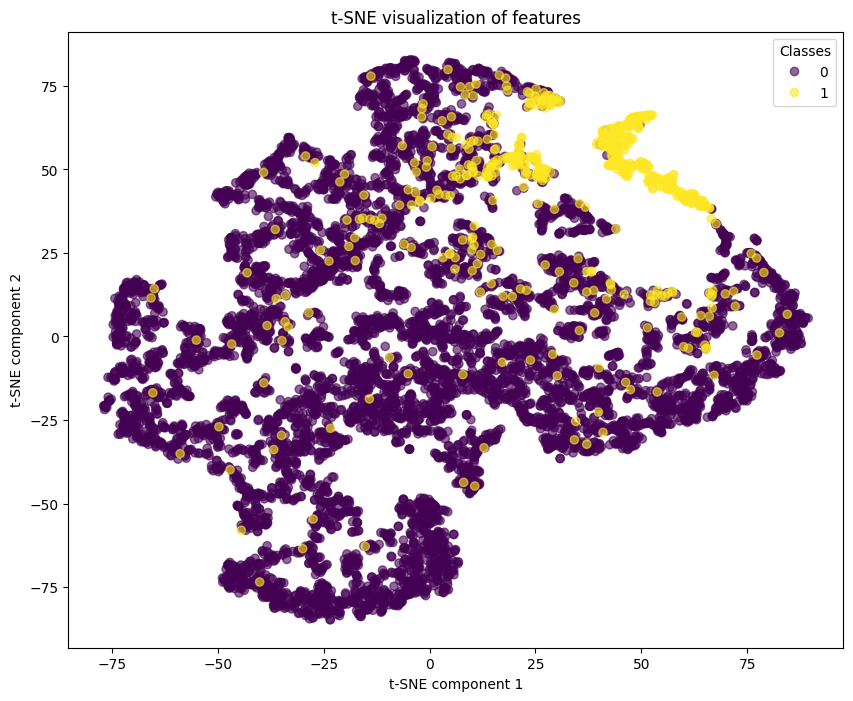

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_np, cmap='viridis', alpha=0.6)

plt.legend(*scatter.legend_elements(), title="Classes")

plt.title("t-SNE visualization of features")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()